# Representation learning with a Deep Belief Network
*   Name: Camilo Betancourt Nieto
*   Student ID: 2087189
*   Date: 23/01/2024





## Introduction


The way that information is represented could simplify or complicate many processing, analysis and interpretation tasks (Goodfellow et al., 2016). With that in mind, instead of using the raw data, some "latent" (or "hidden") variables can be obtained given the internal structure of the data. <br>

By performing unsupervised learning (which can be also thought as "representation learning" or "feature extraction"), this internal representation can be obtained. In this case, in contrast to what happens with supervised algorithms, labeled data is not required. Also, it is not necessary for the learner to have an specific task, even though the resulting representation could be later used for a given task (Zorzi et al., 2023). Moreover, the features obtained could be "recycled" for several purposes. <br>

For these reasons, representation learning is an important part of machine learning. An approach to perform this job is with a Deep Belief Network (DBN). In this project, by using the fashion MNIST dataset, a DBN is implemented and analyzed in order to explore how it is extracting the underlying features of the data and how it behaves when used in some scenarios such as classification, sample reconstruction, robustness to noise, and adversarial attacks.

### Preliminary steps

This project is based on the scripts provided during the lab sessions, which implement a Deep Belief Network with PyTorch. Therefore, it is necessary to import the scripts and the additional libraries required for the execution.


In [ ]:
%%capture

# Downloading the scripts for the implementation of a Deep Belief Network in PyTorch
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}
get_dbn_library()

In [ ]:
# Importing the required libraries
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import torch.nn.functional as functional
from tqdm.notebook import tqdm
from sklearn.metrics import ConfusionMatrixDisplay


from DBN import DBN

In [ ]:
# Choosing dynamically the kind of device used for computations (CPU or GPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Device used: {device}')

Device used: cuda


### Dataset description
Before going into the models, it is important to have an idea of the data that is utilized. In this case, I will work with the Fashion-MNIST dataset.
<br>

The Fashion-MNIST dataset contains images from Zalando's clothing articles. It has a training set of 60.000 examples and a test set of 10.000 examples. It contains 10 balanced classes. As the original MNIST dataset, which has many handwritten digits, the fashion-MNIST examples also consist of 28x28 grayscale images.
<br>

According to the dataset's description, the fashion-MNIST aims to replace the original MNIST dataset as a benchmark for machine learning algorithms. According to this description, MNIST is too easy, overused and can not represent modern computer vision tasks. Thus, the fashion-MNIST aims to improve these characteristics by having a more complex set of images with the same structure as the original MNIST images.
<br>

We start then by downloading the dataset:


In [ ]:
%%capture
# Downloading the dataset (both training and test datasets)

# Training dataset
f_mnist_tr = tv.datasets.FashionMNIST('data/fashion', train=True, download=True,
                                 transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

# Test dataset
f_mnist_te = tv.datasets.FashionMNIST("data/fashion", train=False, download=True,
                                transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

# Normalizing the values by dividing by the maximum of RGB notation (255)
f_mnist_tr.data = f_mnist_tr.data / 255
f_mnist_te.data = f_mnist_te.data / 255

In [ ]:
# Transfering the data to the device
f_mnist_tr.data = f_mnist_tr.data.to(device)
f_mnist_te.data = f_mnist_te.data.to(device)
f_mnist_tr.targets = f_mnist_tr.targets.to(device)
f_mnist_te.targets = f_mnist_te.targets.to(device)

With the data already downloaded, it is possible to visualize some examples of the images for each class:

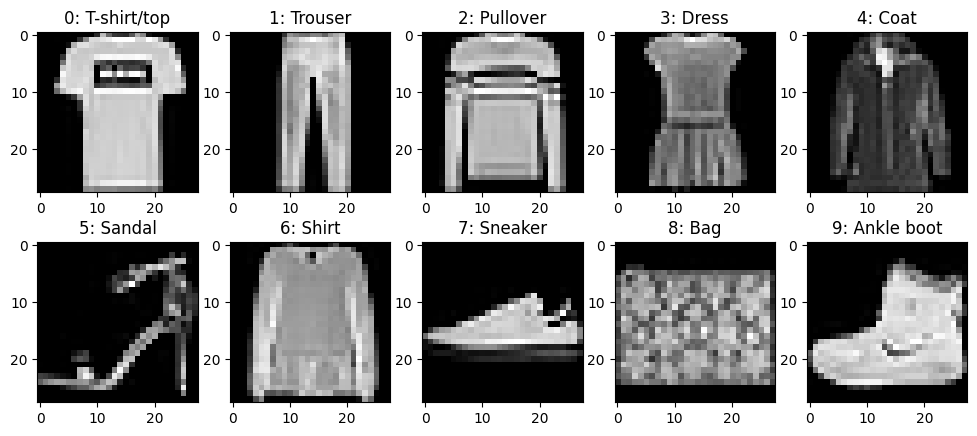

In [ ]:
# Function to plot one example from each class
def plot_labels(id_example=0):
  n_rows = 2
  n_cols = 5
  fig = plt.figure(figsize=(12, 5))
  for i, label in enumerate(f_mnist_tr.classes):
    # Selecting the example corresponding to each class
    idx = int(torch.where(f_mnist_tr.targets==i)[0].cpu()[id_example])
    img = f_mnist_tr.data[idx].cpu()

    # Plotting each example
    fig.add_subplot(n_rows, n_cols, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{i}: {label}')
plot_labels()

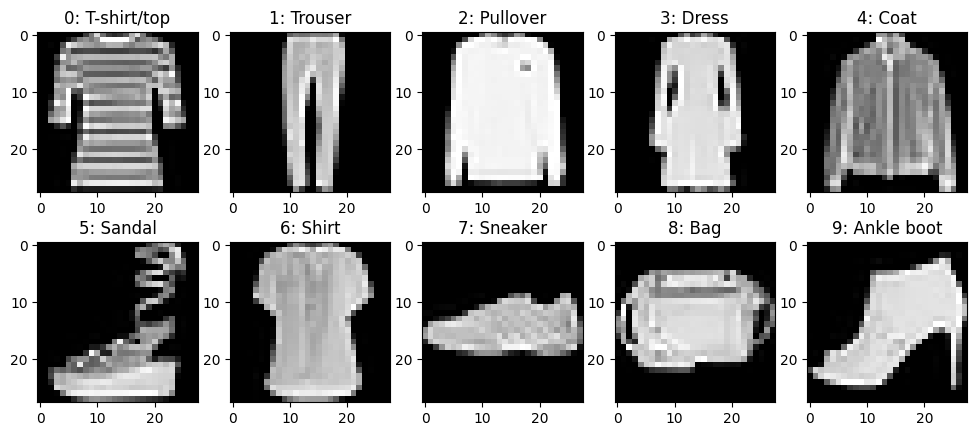

In [ ]:
# Plotting a different example
plot_labels(id_example=5)

## Defining and training Deep Belief Networks

A Deep Belief Network is a model that performs generative learning, which means that, based on a probabilistic framework, aims to capture the probability distribution of the latent variables given on the evidence present in the dataset (the "sensory information").
<br>

The DBN is a hierarchical neural network with recurrent connections that can process information in both directions (from the observed variables to the latent space and viceversa). This way, with a top-down reconstruction, the model is able to generate new samples with similar characteristics to the ones in the observed data.
<br>

The DBN is constructed by stacking Restricted Boltzmann Machines (RBM), which are graphical models that connect a visible input layer with a hidden layer (Hinton, 2002):

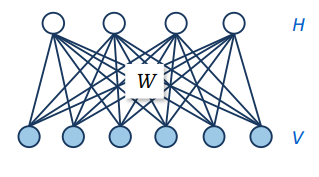

The output of the first RBM becomes the input of the next one, resulting in the hierarchical architecture mentioned above, which aims to learn increasingly more complex and abstract features as one goes deeper into the network (Hinton & Salakhutdinov, 2006):

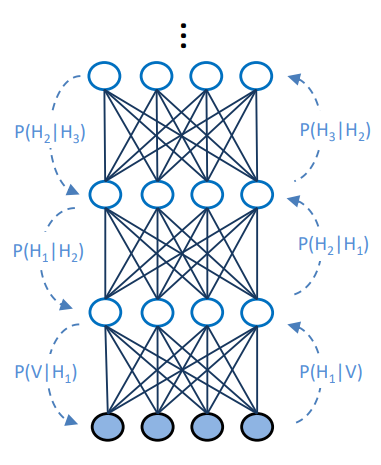

In this case, I am going to try three different architectures for a Deep Belief Network: <br>
* The first one has the same number of neurons as the model that was used in the labs for the MNIST dataset. That model employed 1.700 neurons, distributed across three layers with 400, 500 and 800 nodes in the first, second and third hidden layers, respectively. <br>
 In this case, however, the layer with the most neurons is the first one. This quantity is then reduced in the subsequent layers. <br>
The intuitive idea behind this design is that the first layer attempts to capture a broad set of general low-level features. As we do deeper into the network, the representations at higher levels become more abstract. Since the deeper layers are built on top of the abstractions made in earlier layers, they may require less neurons to represent more complex and specific patterns. In any case, **this will be the benchmark model to make future comparisons** and check if my intuition was correct.
 <br>
* The second architecture has an extra layer, but 30% less of neurons. The extra layer will be arbitrarily assigned to have 25% of the total amount of neurons. <br>
* Finally, the third layer has one hidden layer less (so just two in total), but 30% more neurons.
<br>

The purpose of this is to observe the effects of the depth and quantity of nodes in the network. The percentages used for the reduction and increase in the amount of neurons are arbitrary and are only meant to be used for and exploratory exercise. The architectures are thus defined as follows:

In [ ]:
# Definition of the amount of hidden units for the first model
units_DBN1 = [800, 500, 400]

# Definition of the amount of hidden units for the second model
# It first defines the amount of neurons for the extra layer and then does the
# 30% reduction for each of the layers.
units_DBN2 = [round(x*0.75) for x in units_DBN1]
units_DBN2.append(round(sum(units_DBN1)*0.25))
units_DBN2 = [round(x*0.7) for x in units_DBN2]

# Definition of the amount of hidden units for the third model
# It first removes one layer and redistributes its neurons among the remaining ones
# Then it applies a 30% increase for each of the layers.
units_DBN3 = units_DBN1[:-1]
units_DBN3 = [round(sum(units_DBN1)*x/sum(units_DBN3)) for x in units_DBN3]
units_DBN3 = [round(x*1.3) for x in units_DBN3]

print(f'Model 1 has {sum(units_DBN1)} neurons, distributed as follows: {units_DBN1}')
print(f'Model 2 has {sum(units_DBN2)} neurons, distributed as follows: {units_DBN2}')
print(f'Model 3 has {sum(units_DBN3)} neurons, distributed as follows: {units_DBN3}')

Model 1 has 1700 neurons, distributed as follows: [800, 500, 400]
Model 2 has 1190 neurons, distributed as follows: [420, 262, 210, 298]
Model 3 has 2210 neurons, distributed as follows: [1360, 850]


Now that the architectures are defined, they must be trained to obtain the internal representations. They way a DBN learns is by training each RBM independently, in a layer-wise fashion. As mentioned before, this training is unsupervised and attempts to learn the probability distribution (the model parameters) that makes the observed data plausible by maximizing the likelihood. Thus, the latent variables are hypothesis under the learned distribution.
<br>

The idea is to minimize the dissimilarty between the observed data and the samples generated by the network in its top-down reconstruction. To achieve this, the model's expectations should be computed, but this is computationally expensive. For this reason, an algorithm called Contrastive Divergence (Hinton, 2002) is used. Without going into the details, this approach
iteratively updates the weights based on the difference between the correlations of the visible and the hidden neurons in the positive phase (the pass from visible to hidden) and the negative phase (the pass from hidden to visible neurons).

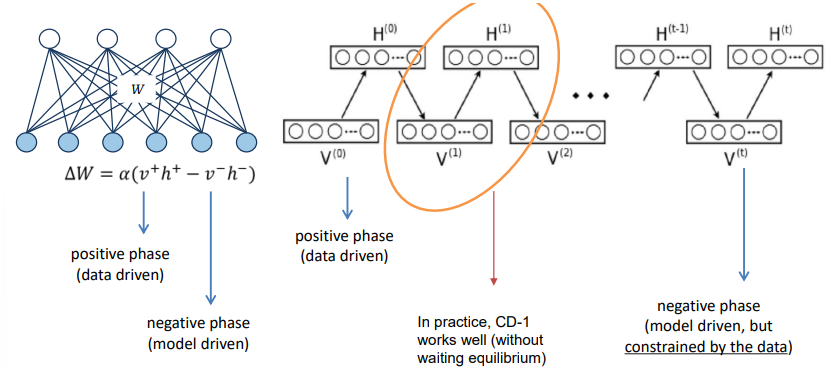

With that information, and the scripts provided, it is possible to train each of the three models. The hyperparameters used are the same as the ones used for the MNIST example because I would like to mantain uniformity in that sense and focus on the architectures:

In [ ]:
# Definition and training of model 1
dbn_f_mnist1 = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=units_DBN1,   # size of hidden layers
                k=1,                            # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())


num_epochs = 50
batch_size = 125

dbn_f_mnist1.train_static(
    f_mnist_tr.data,
    f_mnist_tr.targets,
    num_epochs,
    batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8124     |0.0790       |381.9278   |8.6710     |
|20    |1.6755     |0.0745       |362.4574   |5.9841     |
|30    |1.6647     |0.0731       |375.5998   |6.6050     |
|40    |1.6468     |0.0711       |373.4241   |5.5909     |
|50    |1.6247     |0.0732       |368.9269   |7.3470     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.5976     |0.0202       |189.4540   |3.0963     |
|20    |0.5481     |0.0194       |177.8385   |2.4028     |
|30    |0.5360     |0.0186       |174.4478   |2.7415     |
|40    |0.5303     |0.0185       |172.9471   |2.5549     |
|50    |0.5264     |0.0186       |171.3550   |2.5516     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9593     |0.0323       |140.0355   |2.3384     |
|20    |0.8553     |0.0272       |128.1572   |2.076

In [ ]:
# Definition and training of model 2 (more layers, but less parameters)
dbn_f_mnist2 = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=units_DBN2,   # size of hidden layers
                k=1,                            # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

num_epochs = 50
batch_size = 125

dbn_f_mnist2.train_static(
    f_mnist_tr.data,
    f_mnist_tr.targets,
    num_epochs,
    batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8638     |0.0822       |320.0693   |5.8841     |
|20    |1.7322     |0.0782       |302.1293   |5.9230     |
|30    |1.7001     |0.0766       |298.6230   |6.0852     |
|40    |1.6897     |0.0774       |298.6896   |5.8303     |
|50    |1.6846     |0.0758       |294.5251   |4.8699     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0788     |0.0389       |110.1147   |2.4443     |
|20    |1.0064     |0.0341       |104.9582   |2.0510     |
|30    |0.9864     |0.0351       |103.2399   |2.0209     |
|40    |0.9746     |0.0337       |101.3287   |1.9157     |
|50    |0.9672     |0.0335       |100.0315   |2.1116     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7198     |0.0603       |75.6221   |1.4304     |
|20    |1.5614     |0.0563       |70.0948   |1.4283 

In [ ]:
# Definition and training of model 3 (less layers, but more parameters)
dbn_f_mnist3 = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=units_DBN3,   # size of hidden layers
                k=1,                            # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

num_epochs = 50
batch_size = 125

dbn_f_mnist3.train_static(
    f_mnist_tr.data,
    f_mnist_tr.targets,
    num_epochs,
    batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8012     |0.0792       |409.9206   |6.8009     |
|20    |1.6755     |0.0752       |389.8567   |5.9179     |
|30    |1.6665     |0.0726       |430.6415   |8.2458     |
|40    |1.6581     |0.0719       |441.9478   |8.6996     |
|50    |1.6333     |0.0707       |440.5868   |6.2892     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.3726     |0.0133       |254.9442   |3.6073     |
|20    |0.3399     |0.0116       |244.8132   |3.2240     |
|30    |0.3313     |0.0109       |244.7260   |3.0629     |
|40    |0.3272     |0.0107       |243.1483   |3.2909     |
|50    |0.3254     |0.0108       |242.9024   |3.5877     |


## Analyzing the internal representations

### Feature visualization

One way to analyze the internal representations of the network is by visualizing the receptive fields of the hidden neurons. This term refers to the region of the sensory space that activates each neuron.
<br>

Once the model is trained, this can be done for each hidden neuron by plotting the strength of the connection with each of the visible units (the observed data). If a given pixel has a strong connection with a given neuron in the hidden space, meaning that it has an influence into triggering the activation, it is shown in the plot with higher values. That way, it is possible to locate the areas of the input to which the neurons respond (Zorzi et al., 2013).

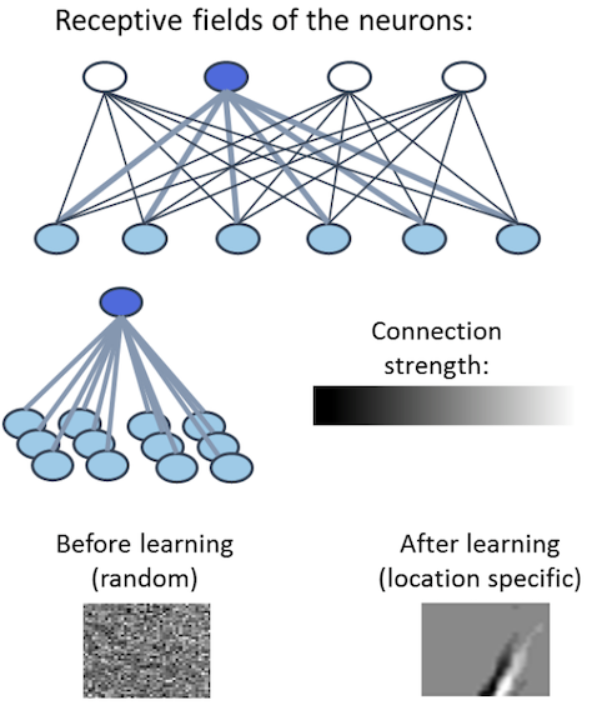

Apart from the first layer, to visualize the receptive fields of the hidden layers as images, it is necessary to first compute a projection of the weights into a space with the same dimensionality as the input. <br>

The receptive fields are obtained for the neurons of each hidden layer and a subset of them are shown below.

In [ ]:
# Definition of functions necessary to visualize the receptive fields
# (these will be later used in other functions)

# Function to get the trained weights
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

# Function to apply a threshold to make the plots less noisy
def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

# Function to scale the weights to make them comparable with each other (they might have different ranges)
def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

# Function to plot the receptive fields of the neurons
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

In [ ]:
# Definition of functions to project the receptive fields for different layers

# Projecting the receptive fields for the first layer
def proj_weights_layer1(dbn):
  w1 = get_weights(dbn, layer=0)
  w1 = apply_threshold(w1, 0.1)
  w1 = apply_min_max_scaler(w1)

  plot_layer_receptive_fields(w1.T)

# Projecting the receptive fields for the second layer
def proj_weights_layer2(dbn):
  w1 = get_weights(dbn, layer=0)
  w2 = get_weights(dbn, layer=1)

  w1 = apply_threshold(w1, 0.1)
  w2 = apply_threshold(w2, 0.1)

  w_product = (w1 @ w2)  # here we do the projection
  w_product = apply_threshold(w_product, 0.1)
  w_product = apply_min_max_scaler(w_product)

  plot_layer_receptive_fields(w_product.T)

# Projecting the receptive fields for the third layer
def proj_weights_layer3(dbn):
  w1 = get_weights(dbn, layer=0)
  w2 = get_weights(dbn, layer=1)
  w3 = get_weights(dbn, layer=2)

  w1 = apply_threshold(w1, 0.1)
  w2 = apply_threshold(w2, 0.1)
  w3 = apply_threshold(w3, 0.1)

  w_product_12 = (w1 @ w2)
  w_product_23 = (w_product_12 @ w3)
  w_product_23 = apply_threshold(w_product_23, 0.1)
  w_product_23 = apply_min_max_scaler(w_product_23)

  plot_layer_receptive_fields(w_product_23.T)

# Projecting the receptive fields for the fourth layer
def proj_weights_layer4(dbn):
  w1 = get_weights(dbn, layer=0)
  w2 = get_weights(dbn, layer=1)
  w3 = get_weights(dbn, layer=2)
  w4 = get_weights(dbn, layer=3)

  w1 = apply_threshold(w1, 0.1)
  w2 = apply_threshold(w2, 0.1)
  w3 = apply_threshold(w3, 0.1)
  w4 = apply_threshold(w4, 0.1)

  w_product_12 = (w1 @ w2)
  w_product_23 = (w_product_12 @ w3)
  w_product_34 = (w_product_23 @ w4)
  w_product_34 = apply_threshold(w_product_34, 0.1)
  w_product_34 = apply_min_max_scaler(w_product_34)

  plot_layer_receptive_fields(w_product_34.T)

#### Model 1 - Receptive fields

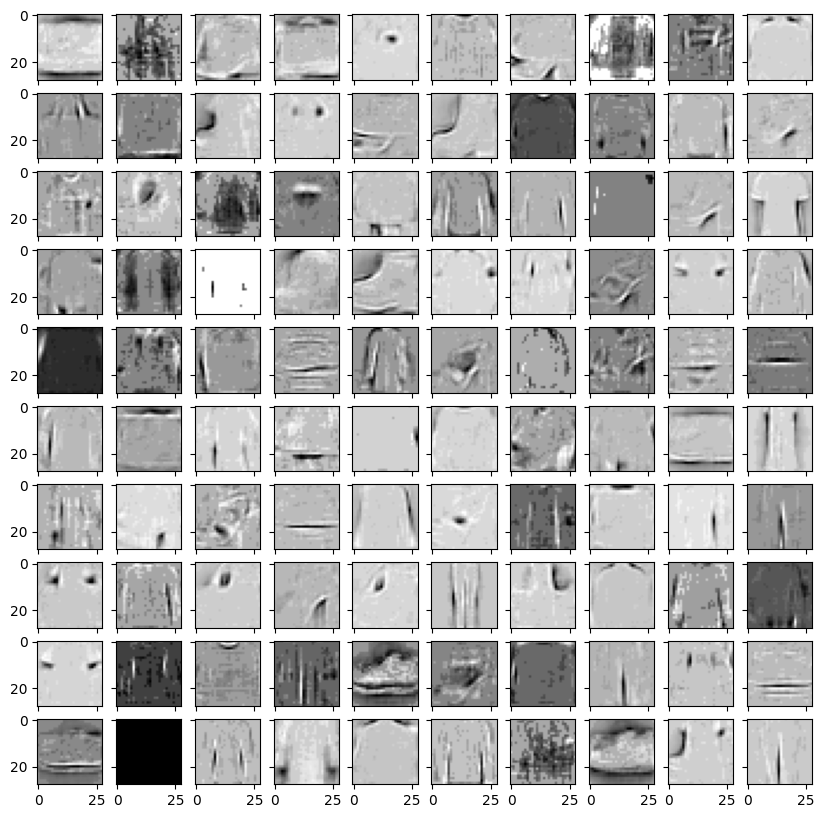

In [ ]:
proj_weights_layer1(dbn_f_mnist1)

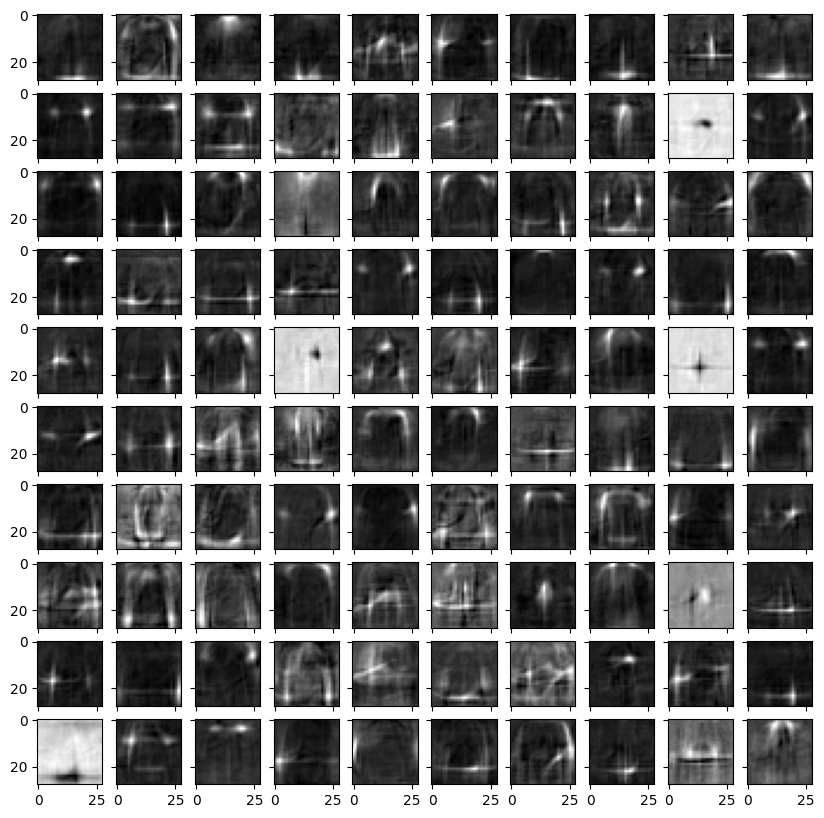

In [ ]:
proj_weights_layer2(dbn_f_mnist1)

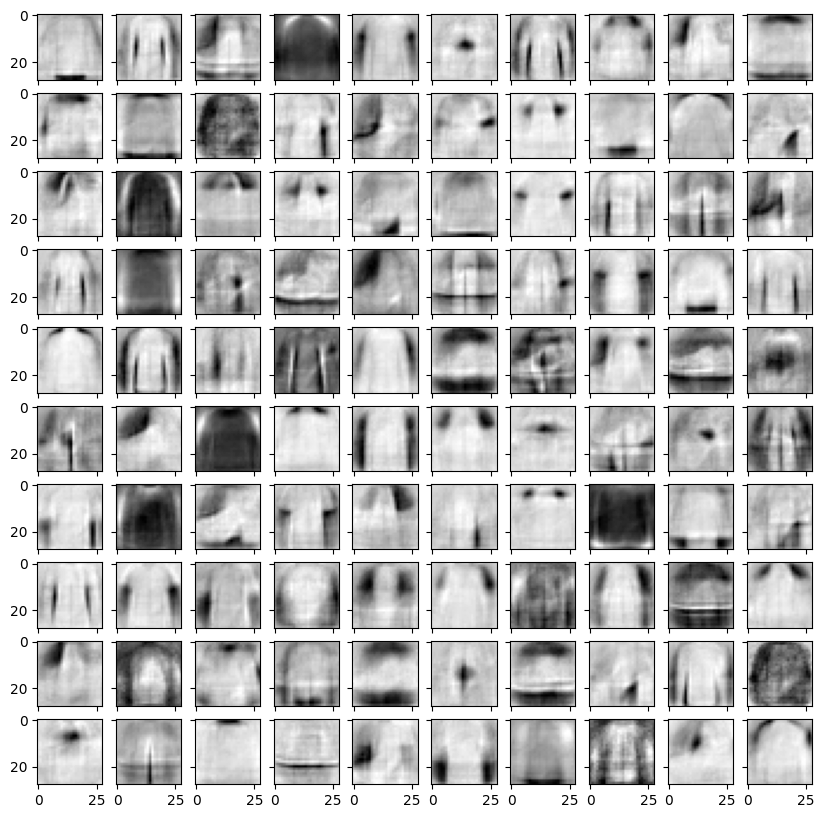

In [ ]:
proj_weights_layer3(dbn_f_mnist1)

In the first place, we can see that the plots of the receptive fields are different for each level. There is a contrast between what is shown in the receptive fields of the subsequent layers. What this means is that it is likely that each of the hidden layers is focusing on different features of the data.
<br>

Also, from the receptive fields of the first layer, we can already see some shapes that resemble the ones in the input. However, these shapes are not yet well-defined and are more general than what we observe in the next layers (they respond to a broader range of stimuli). Since each neuron is connected to the entire input (unlike in a Convolutional Neural Network, where neurons focus on specific parts of the image), it makes sense that some neurons in the first layer already react to shapes across the entire input image rather than focusing on specific local features.
<br>

 On the other hand, the receptive fields of the neurons in the second layer appear to highlight different parts of the image, which should be built upon the representations learned in the first layer. This kind of contrast confirms the hierarchical aspect of the network, where each layer is expected to show a more disentangled representation of the input.
 <br>

 In the last layer, we can distinguish shapes that might be considered as "prototypes" of the input images. This outcome is a consequence of a more complex representation that captures the hidden structure of the raw pixels that now reveal distinctive shapes of clothing articles.

#### Model 2 - Receptive fields

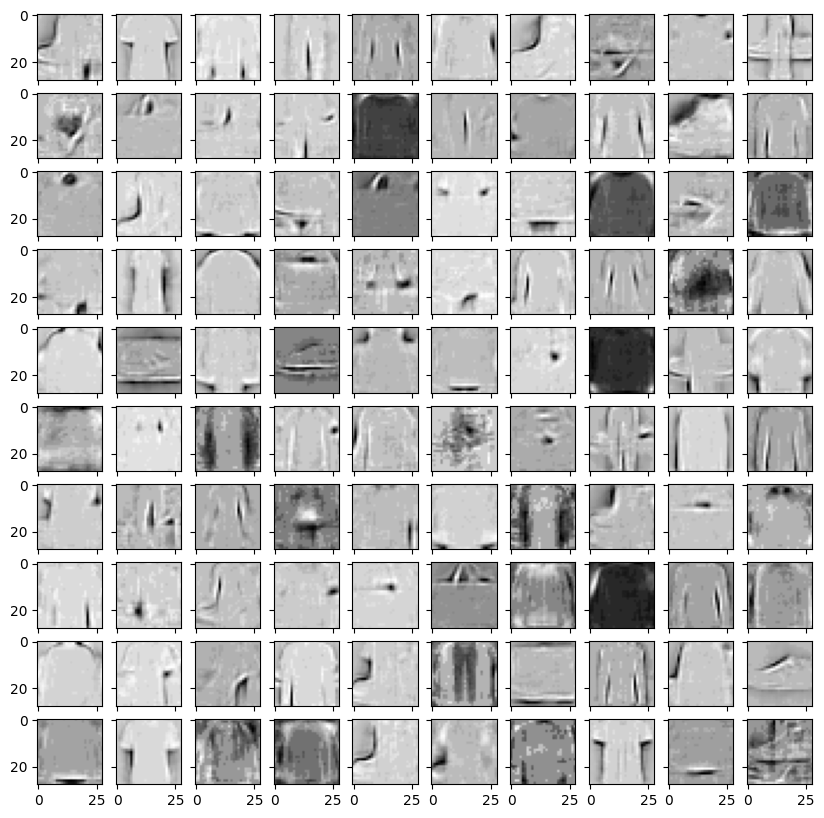

In [ ]:
proj_weights_layer1(dbn_f_mnist2)

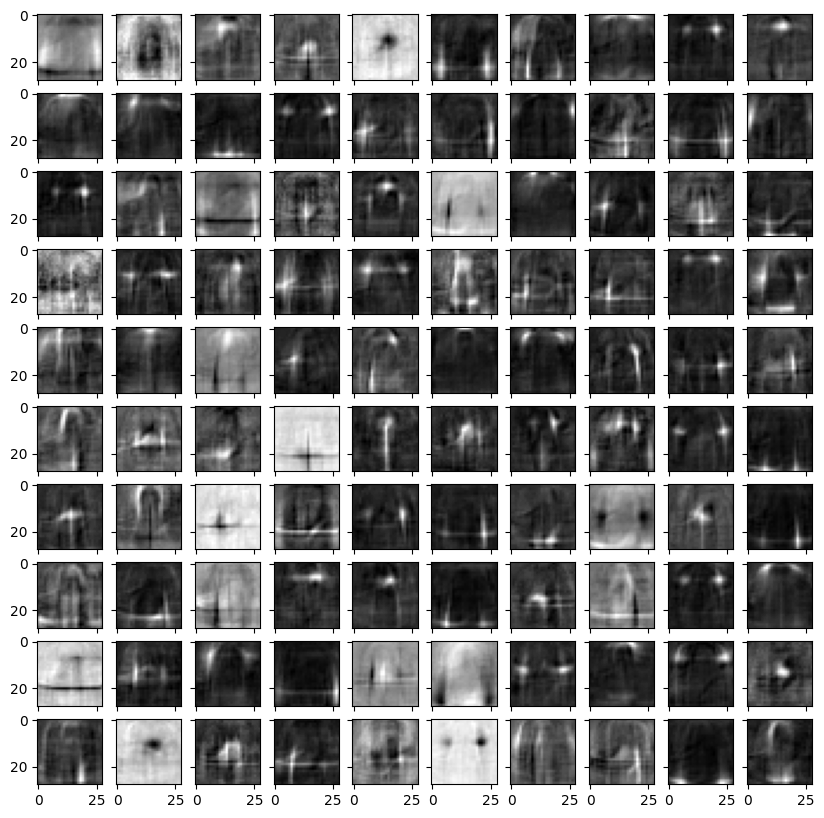

In [ ]:
proj_weights_layer2(dbn_f_mnist2)

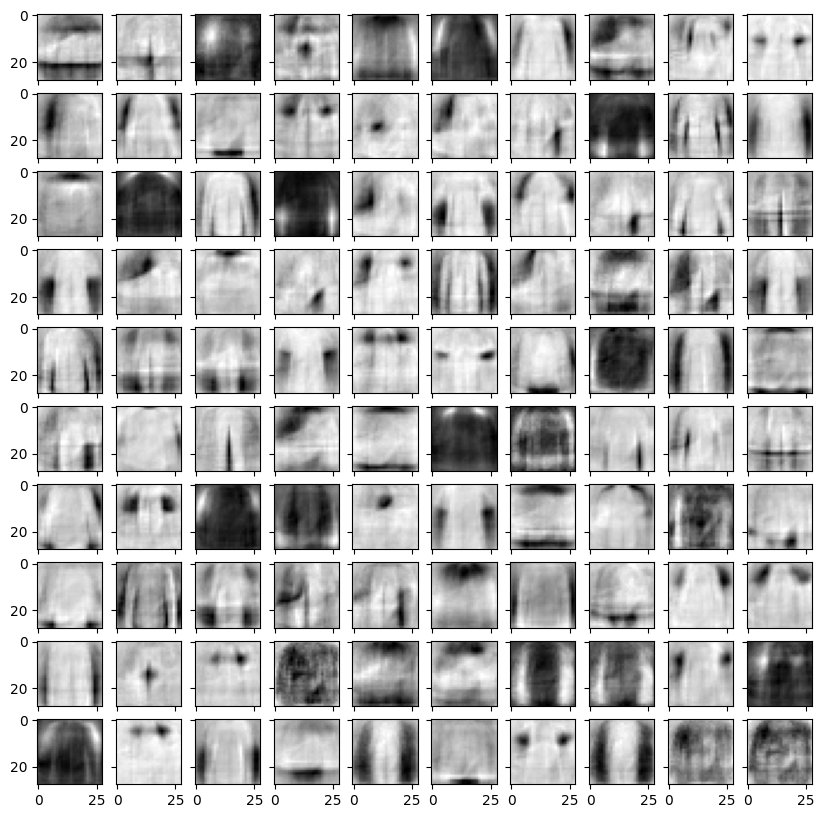

In [ ]:
proj_weights_layer3(dbn_f_mnist2)

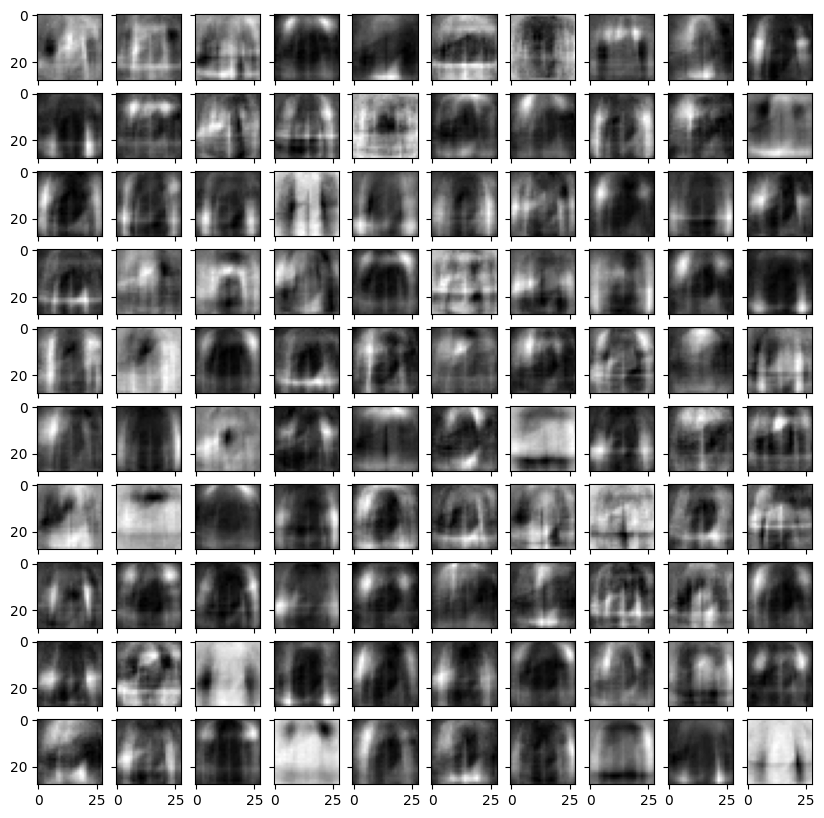

In [ ]:
proj_weights_layer4(dbn_f_mnist2)

In this case, the patterns are similar to what we saw in the first model. However, what is intriguing about this version is that the extra layer allows us to observe a sort of "periodicity" among layers. Specifically, levels 2 and 4 exhibit more similarity to each other than layers 1 and 3. Again, this could be due to the hierarchical structure of the network, where each layer focuses on different things with respect to the previous one. Later on we will assess how well this representation performs when tested in a classification task.

#### Model 3 - Receptive fields

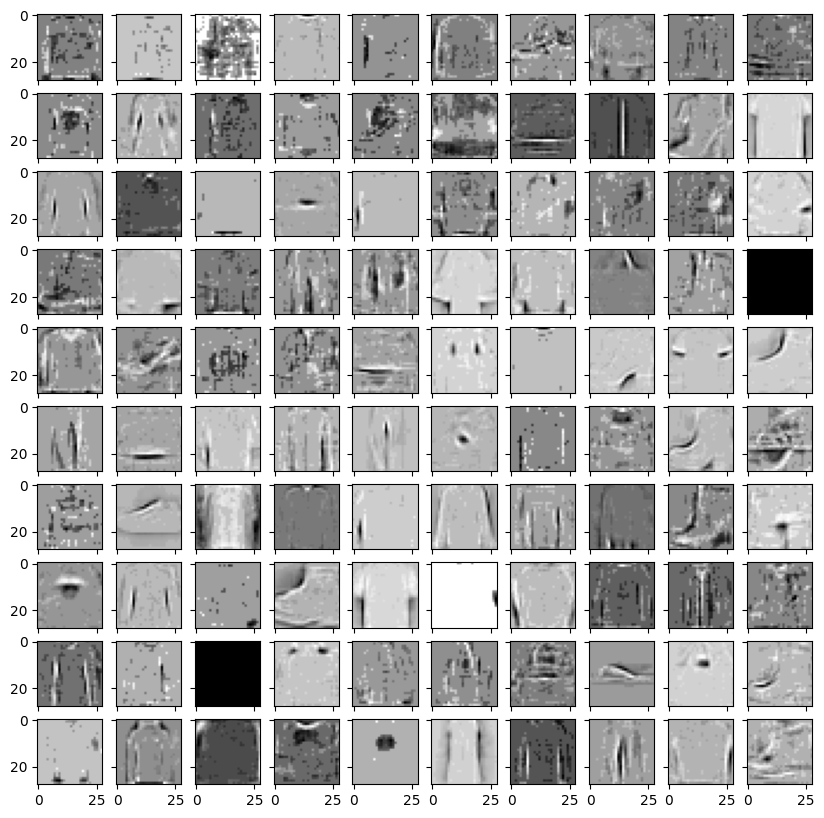

In [ ]:
proj_weights_layer1(dbn_f_mnist3)

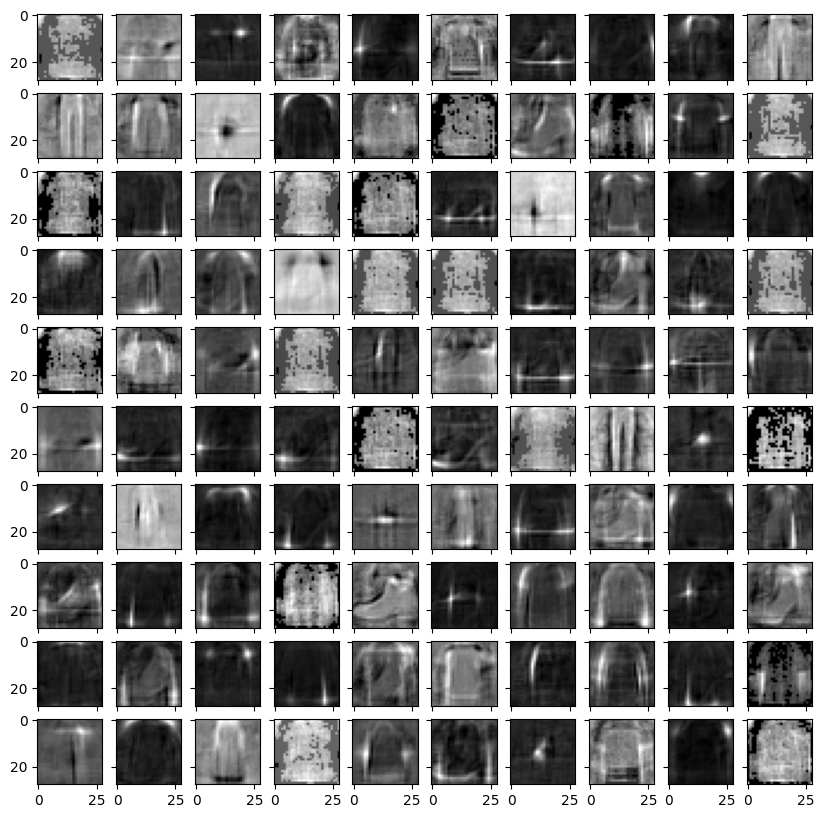

In [ ]:
proj_weights_layer2(dbn_f_mnist3)

Once again, this model shows a similar behavior to the previous two in their first two layers. What stands out in this version is the presence of some receptive fields in the second layer that display irregular patterns with many dark pixels -areas that do not lead to activations-. Given that this is the model with the most nodes, one possible explanation for this phenomenon could be that there are some redundant neurons that fail to capture significant patterns that are not already captured by other nodes. This could also be a case of overfitting, where the network is starting to model some of the noise present in the data.

### Hierarchical clustering

Another way to analyze the hidden representations is by plotting a dendrogram, which is a tree-like diagram that represents the hierarchical clustering.
<br>

The way this is done in this case is by obtaining the mean values of the hidden variables for each class within the latent space of each layer. Then, these mean values are clustered, so the classes that are at a short distance in the latent space are represented closely in the diagram. This is a way to visualize how similar the internal representations of the classes are throughout the network.
<br>

Like in the case of the receptive fields, this process is made for each of the hidden layers.
<br>

Before we look at the dendrograms, it is useful to remember what the labels for the classes meant:

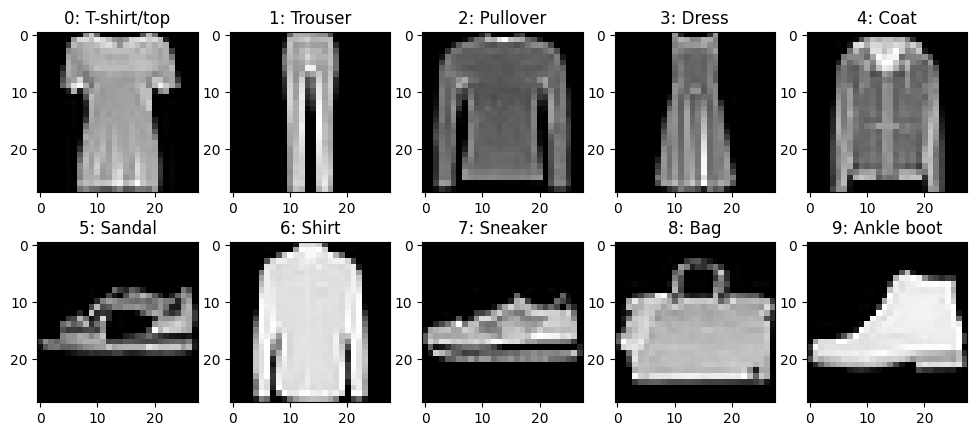

In [ ]:
# Plotting a different example
plot_labels(id_example=3)

In [ ]:
# Function to compute the hidden representations of each layer by using the weights
# of each RBM.
def get_kth_layer_repr(input, k, device, dbn):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
# Functions to get the centroids of the hidden representations for each class
def get_mask(label):  # we use this function to filter by class
  labels = f_mnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

# Function to execute the clustering algorithm and visualize it in a dendogram
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)


In [ ]:
# Getting the hidden representations for each model

# Function to get all the hidden representations in a list
def get_all_hidden_repr(dbn, input):
  list_hidden_repr = []
  for k in range(len(dbn.rbm_layers)):
    if k == 0 :
      hidden_repr_k = get_kth_layer_repr(input=input.data, k=k, device=device,dbn=dbn)
    else:
      hidden_repr_k = get_kth_layer_repr(input=list_hidden_repr[k-1], k=k, device=device,dbn=dbn)
    list_hidden_repr.append(hidden_repr_k)
  return list_hidden_repr

# Training set: Getting all the hidden representations for each model
hidden_repr_model1 = get_all_hidden_repr(dbn_f_mnist1, input=f_mnist_tr)
hidden_repr_model2 = get_all_hidden_repr(dbn_f_mnist2, input=f_mnist_tr)
hidden_repr_model3 = get_all_hidden_repr(dbn_f_mnist3, input=f_mnist_tr)

# Test set: Getting all the hidden representations for each model
# (these will be used later for testing)
hidden_repr_model1_test = get_all_hidden_repr(dbn_f_mnist1, input=f_mnist_te)
hidden_repr_model2_test = get_all_hidden_repr(dbn_f_mnist2, input=f_mnist_te)
hidden_repr_model3_test = get_all_hidden_repr(dbn_f_mnist3, input=f_mnist_te)

#### Model 1 - Dendrogram of the hidden representations

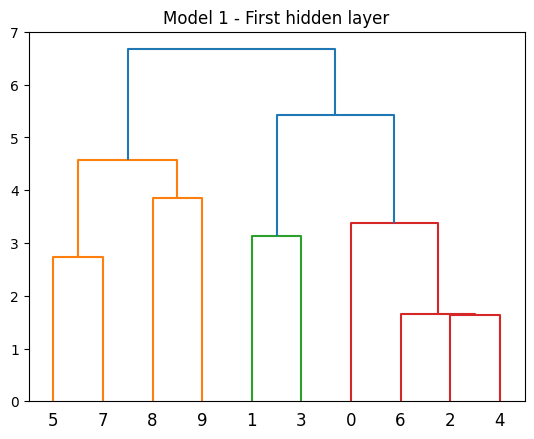

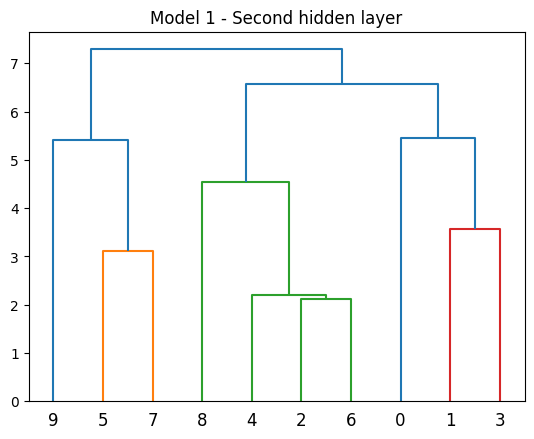

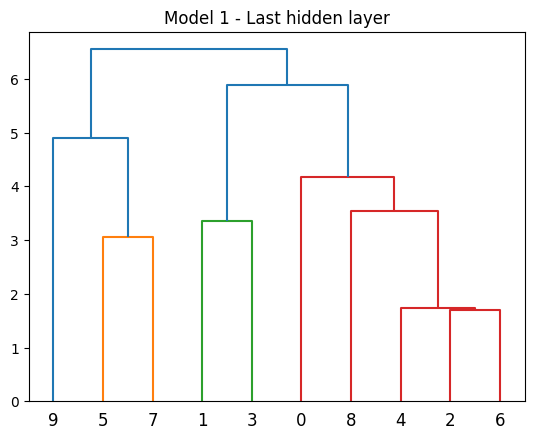

In [ ]:
# Executing the clustering of the hidden representations
list_mean_hidd_repr_matrix_model1 = [get_hidden_reprs_matrix(hidden_repr_model1[i]) for i in range(len(hidden_repr_model1))]


plot_dendrogram(list_mean_hidd_repr_matrix_model1[0], "Model 1 - First hidden layer")
plot_dendrogram(list_mean_hidd_repr_matrix_model1[1], "Model 1 - Second hidden layer")
plot_dendrogram(list_mean_hidd_repr_matrix_model1[2], "Model 1 - Last hidden layer")

With this approach we can observe that the clustering does change from one layer to the next one, which means that the features that the networks considers distinctive and representative can indeed vary as one goes into the deeper layers.
<br>

Also, we can see that the representations are similar to what one human could think of, For example, from the last layer, we can see that sandals, sneakers, and ankle boots are located closer to each other than pullovers, coats and shirts.

#### Model 2 - Dendrogram of the hidden representations

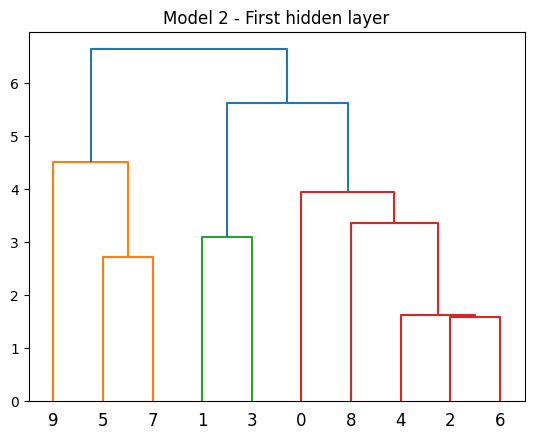

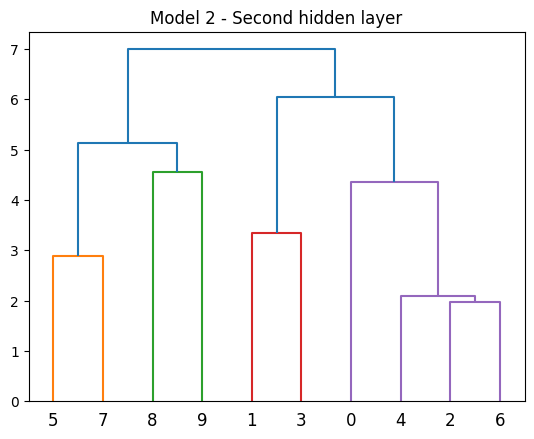

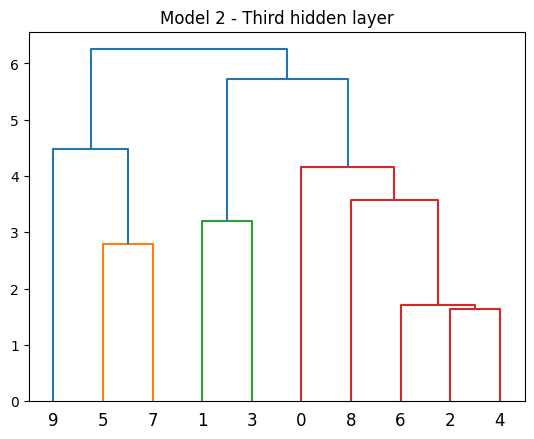

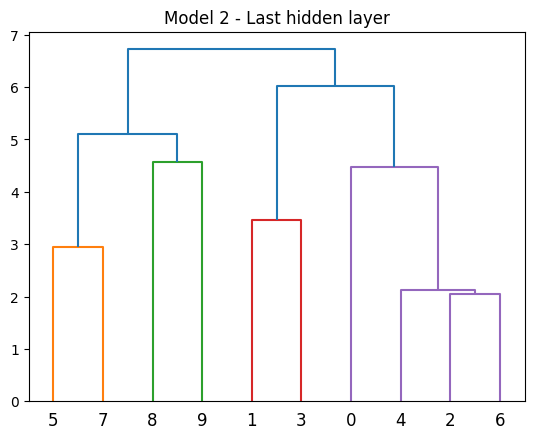

In [ ]:
# Executing the clustering of the hidden representations
list_mean_hidd_repr_matrix_model2 = [get_hidden_reprs_matrix(hidden_repr_model2[i]) for i in range(len(hidden_repr_model2))]

plot_dendrogram(list_mean_hidd_repr_matrix_model2[0], "Model 2 - First hidden layer")
plot_dendrogram(list_mean_hidd_repr_matrix_model2[1], "Model 2 - Second hidden layer")
plot_dendrogram(list_mean_hidd_repr_matrix_model2[2], "Model 2 - Third hidden layer")
plot_dendrogram(list_mean_hidd_repr_matrix_model2[3], "Model 2 - Last hidden layer")

For this model, we observe a clustering similar to that of the benchmark model. Specifically, the formation of the groups appears alike in both models, although there seems to be a change in the distance between groups. In this case, at the last hidden layer, trousers and dresses are the farthest classes from sandals, sneakers, and ankle boots.

#### Model 3 - Dendrogram of the hidden representations

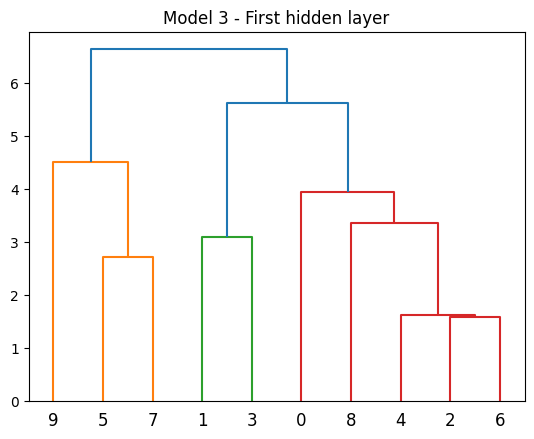

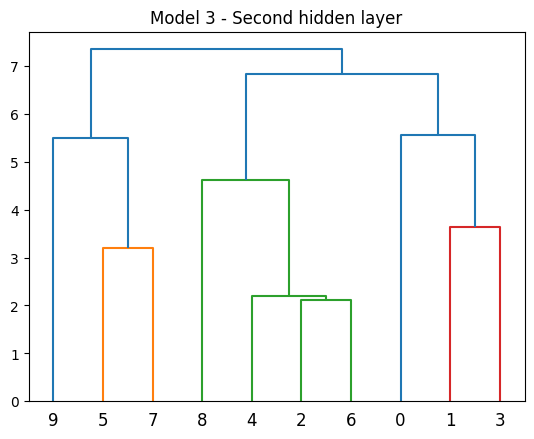

In [ ]:
# Executing the clustering of the hidden representations
list_mean_hidd_repr_matrix_model3 = [get_hidden_reprs_matrix(hidden_repr_model3[i]) for i in range(len(hidden_repr_model3))]

plot_dendrogram(list_mean_hidd_repr_matrix_model2[0], "Model 3 - First hidden layer")
plot_dendrogram(list_mean_hidd_repr_matrix_model3[1], "Model 3 - Second hidden layer")

Unlike the previous versions, this last dendrogram groups ankle boots and bags together, while sneakers and sandals remain paired. Bags, in fact, appear to be the class that is least consistent across diagrams. From a human perspective, I believe it is a category that is challenging to group with the others.

### Linear read-outs at different levels of the model hierarchy

Finally, in terms of understanding the hidden features of the networks, some linear read-outs can be performed in order to evaluate how good the internal representations are with respect to a linear classification task. What is done is adding an output layer with linear activations on top of the hidden variables. This new layer has 10 neurons, which correspond to a each of the classes. It is trained in a supervised way with backpropagation. This process allows to do classification with the hidden representations as inputs instead of the raw pixels.

For this purpose, I used some functions to wrap the training process for each of the models.

In [ ]:
# Class to a create the object for a linear read-out
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

# Function instantiate a linear classifier for each hidden layer of a given DBN
def linear_class_hidden_layers(dbn):
  list_linear_classifiers = []
  for i in range(len(dbn.rbm_layers)):
    layer_size = dbn.rbm_layers[i].W.shape[1]
    linear_classifier = LinearModel(layer_size).to(device)
    list_linear_classifiers.append(linear_classifier)
  return list_linear_classifiers

In [ ]:
# Function to train the linear classifiers on the hidden
# representations from each layer using the actual labels of the fashion MNIST dataset as targets
def train(model, input, epochs = 1500):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(input).squeeze()
    targets = f_mnist_tr.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

# Function to train the linear classifiers of each of the hidden layers of a given DBN
def train_linear_all_layers(list_classifiers, list_hidden_repr):
  for i, linear in enumerate(list_classifiers):
    print(f'\nTraining the classifier for layer {i+1}:')
    train(linear, list_hidden_repr[i])

In [ ]:
# Function to compute the accuray given the predictions and the targets
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

# Function to perform the test for each of the layers,
# given the test hidden representations and the linear classifiers of a given model
def test_all_layers(list_test_hidden_repr, list_linear_classifiers, conf_matrix=False, verbose=False):
  list_accuracies = []
  for i, hidden_repr in enumerate(list_test_hidden_repr):
    linear = list_linear_classifiers[i]
    predictions_test = linear(hidden_repr)
    accuracy = compute_accuracy(predictions_test, f_mnist_te.targets)
    list_accuracies.append(accuracy)
    if verbose:
      print(f'Accuracy for layer {i+1}: {accuracy}')
    if conf_matrix:
      ConfusionMatrixDisplay.from_predictions(f_mnist_te.targets.detach().cpu().numpy(), predictions_test.max(axis=1).indices.detach().cpu().numpy())
      plt.show()
      print('\n')
  return list_accuracies


First, these linear classifiers must be trained (with the train set). This is done for each layer.

#### Model 1 - Linear read-outs

In [ ]:
# Definition of the linear classifiers for all the layers of the model
linear_classifiers_model1 = linear_class_hidden_layers(dbn_f_mnist1)

# Training of all the linear classifiers
train_linear_all_layers(linear_classifiers_model1, hidden_repr_model1)


Training the classifier for layer 1:
epoch :   1/1500, loss = 2.3107
epoch : 101/1500, loss = 0.9190
epoch : 201/1500, loss = 0.7191
epoch : 301/1500, loss = 0.6384
epoch : 401/1500, loss = 0.5922
epoch : 501/1500, loss = 0.5610
epoch : 601/1500, loss = 0.5381
epoch : 701/1500, loss = 0.5203
epoch : 801/1500, loss = 0.5059
epoch : 901/1500, loss = 0.4940
epoch : 1001/1500, loss = 0.4839
epoch : 1101/1500, loss = 0.4752
epoch : 1201/1500, loss = 0.4676
epoch : 1301/1500, loss = 0.4608
epoch : 1401/1500, loss = 0.4548

Training the classifier for layer 2:
epoch :   1/1500, loss = 2.3038
epoch : 101/1500, loss = 0.7877
epoch : 201/1500, loss = 0.6457
epoch : 301/1500, loss = 0.5856
epoch : 401/1500, loss = 0.5496
epoch : 501/1500, loss = 0.5248
epoch : 601/1500, loss = 0.5062
epoch : 701/1500, loss = 0.4917
epoch : 801/1500, loss = 0.4800
epoch : 901/1500, loss = 0.4702
epoch : 1001/1500, loss = 0.4619
epoch : 1101/1500, loss = 0.4547
epoch : 1201/1500, loss = 0.4484
epoch : 1301/1500, l

Once the classifiers are trained, they can be evaluated with an overall accuracy and a confusion matrix (which compares the true label with the prediction made by the model):

Model 1 results
Accuracy for layer 1: 0.8352999687194824


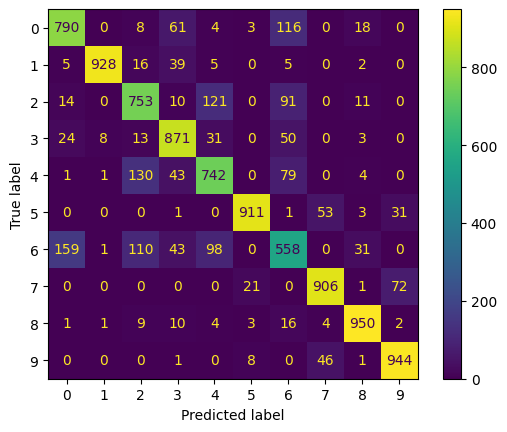



Accuracy for layer 2: 0.8392999768257141


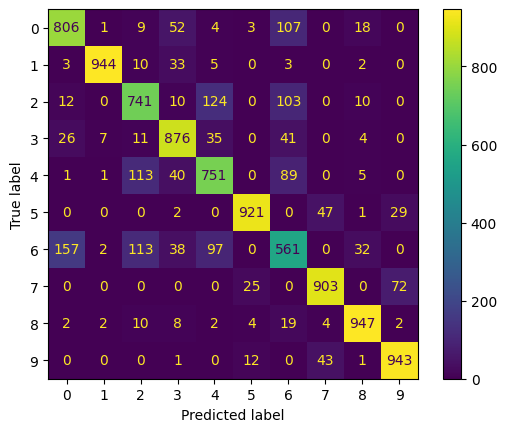



Accuracy for layer 3: 0.8361999988555908


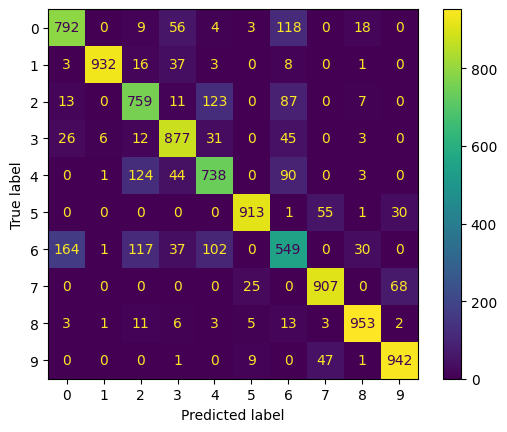

In [ ]:
# Testing for the linear classifiers corresponding to the layers of the model
print('Model 1 results')
acc_mod1 = test_all_layers(hidden_repr_model1_test, linear_classifiers_model1, conf_matrix=True, verbose=True)

In this benchmark model, we observe an improvement from the first to the second layer. However, the accuracy in the third layer decreases slightly compared to the test set. Although the difference is small, we would expect to see improvements with every layer. This could indicate that the network is struggling to generalize its knowledge effectively, and the third layer may not be capturing relevant features as well as the second one. Additionally, certain hyperparameters related to the training process could have influenced these results, but in this case, I am directing my focus on the architecture of the DBN. <br>

Also, concerning the confusion matrix, as most of the observations are correctly classified (the overall accuracy is over 80%), we can observe a pattern where the diagonal is highlighted. Nonetheless, it appears that the shirts (label 6) present the greatest challenge for the model in terms of classification. This class is most frequently confused with t-shirts, pullovers, and coats (labels 0, 2, and 4).

#### Model 2 - Linear read-outs

In [ ]:
# Definition of the linear classifiers for all the layers of the model
linear_classifiers_model2 = linear_class_hidden_layers(dbn_f_mnist2)

# Training of all the linear classifiers
train_linear_all_layers(linear_classifiers_model2, hidden_repr_model2)


Training the classifier for layer 1:
epoch :   1/1500, loss = 2.2954
epoch : 101/1500, loss = 0.9115
epoch : 201/1500, loss = 0.7169
epoch : 301/1500, loss = 0.6387
epoch : 401/1500, loss = 0.5936
epoch : 501/1500, loss = 0.5631
epoch : 601/1500, loss = 0.5406
epoch : 701/1500, loss = 0.5231
epoch : 801/1500, loss = 0.5090
epoch : 901/1500, loss = 0.4973
epoch : 1001/1500, loss = 0.4874
epoch : 1101/1500, loss = 0.4788
epoch : 1201/1500, loss = 0.4713
epoch : 1301/1500, loss = 0.4647
epoch : 1401/1500, loss = 0.4588

Training the classifier for layer 2:
epoch :   1/1500, loss = 2.3077
epoch : 101/1500, loss = 0.8026
epoch : 201/1500, loss = 0.6566
epoch : 301/1500, loss = 0.5964
epoch : 401/1500, loss = 0.5606
epoch : 501/1500, loss = 0.5359
epoch : 601/1500, loss = 0.5176
epoch : 701/1500, loss = 0.5032
epoch : 801/1500, loss = 0.4915
epoch : 901/1500, loss = 0.4819
epoch : 1001/1500, loss = 0.4737
epoch : 1101/1500, loss = 0.4667
epoch : 1201/1500, loss = 0.4606
epoch : 1301/1500, l

Model 2 results
Accuracy for layer 1: 0.835099995136261


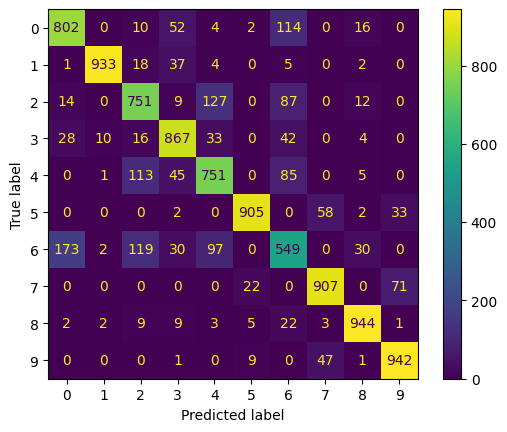



Accuracy for layer 2: 0.8345999717712402


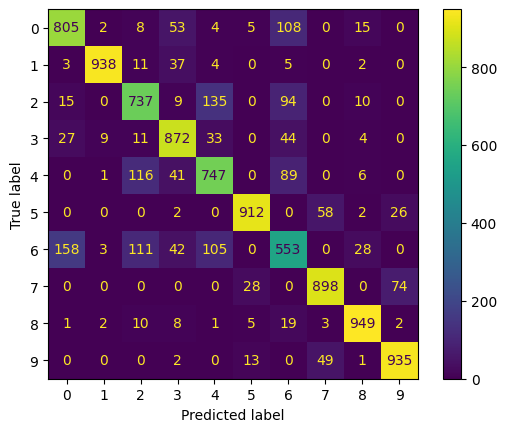



Accuracy for layer 3: 0.8325999975204468


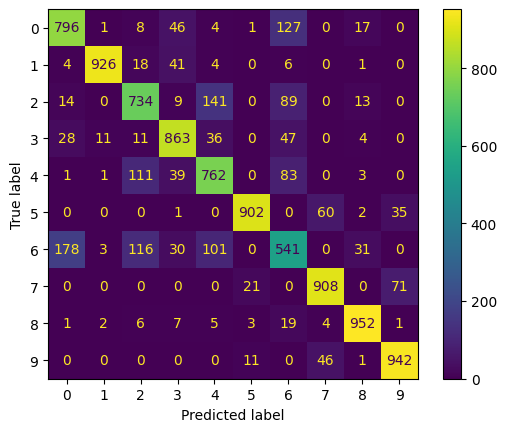



Accuracy for layer 4: 0.8367999792098999


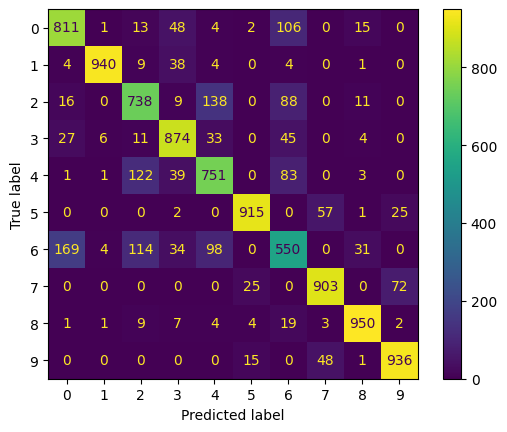

In [ ]:
# Testing for the linear classifiers corresponding to the layers of the model
print('Model 2 results')
acc_mod2 = test_all_layers(hidden_repr_model2_test, linear_classifiers_model2, conf_matrix=True, verbose=True)

This DBN shows an inconsistent performance as one goes deeper into the architecture. There is not a constant improvement as we advance across the layers. Once more, this could be a sign that in this case adding more layers does not necessarily represent the data in a better way with respect to a classification task. <br>

Additionally, we can  observe that this model, with more layers but less neurons, has a worse overall performance than the benchmark model (when comparing the best accuracy in both cases).

#### Model 3 - Linear read-outs

In [ ]:
# Definition of the linear classifiers for all the layers of the model
linear_classifiers_model3 = linear_class_hidden_layers(dbn_f_mnist3)

# Training of all the linear classifiers
train_linear_all_layers(linear_classifiers_model3, hidden_repr_model3)


Training the classifier for layer 1:
epoch :   1/1500, loss = 2.2732
epoch : 101/1500, loss = 0.9038
epoch : 201/1500, loss = 0.7135
epoch : 301/1500, loss = 0.6358
epoch : 401/1500, loss = 0.5906
epoch : 501/1500, loss = 0.5600
epoch : 601/1500, loss = 0.5373
epoch : 701/1500, loss = 0.5195
epoch : 801/1500, loss = 0.5051
epoch : 901/1500, loss = 0.4931
epoch : 1001/1500, loss = 0.4829
epoch : 1101/1500, loss = 0.4741
epoch : 1201/1500, loss = 0.4663
epoch : 1301/1500, loss = 0.4595
epoch : 1401/1500, loss = 0.4533

Training the classifier for layer 2:
epoch :   1/1500, loss = 2.3144
epoch : 101/1500, loss = 0.7752
epoch : 201/1500, loss = 0.6367
epoch : 301/1500, loss = 0.5780
epoch : 401/1500, loss = 0.5427
epoch : 501/1500, loss = 0.5184
epoch : 601/1500, loss = 0.5002
epoch : 701/1500, loss = 0.4861
epoch : 801/1500, loss = 0.4746
epoch : 901/1500, loss = 0.4651
epoch : 1001/1500, loss = 0.4570
epoch : 1101/1500, loss = 0.4500
epoch : 1201/1500, loss = 0.4439
epoch : 1301/1500, l

Model 3 results
Accuracy for layer 1: 0.8384999632835388


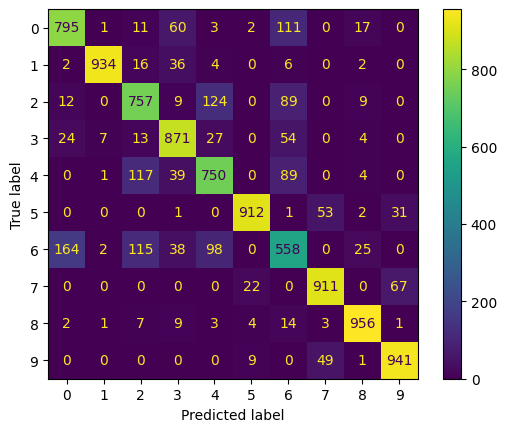



Accuracy for layer 2: 0.8420000076293945


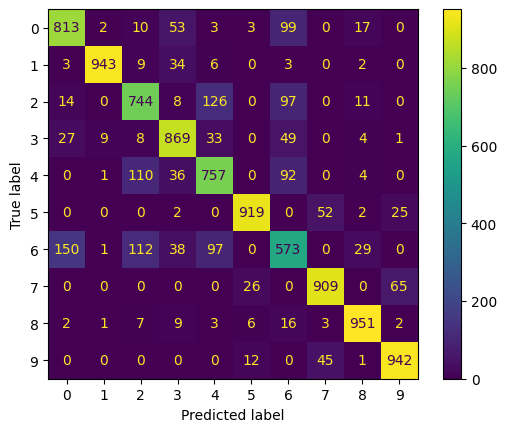

In [ ]:
# Testing for the linear classifiers corresponding to the layers of the model
print('Model 3 results')
acc_mod3 = test_all_layers(hidden_repr_model3_test, linear_classifiers_model3, conf_matrix=True, verbose=True)

In contrast, what we observe in this case is that the overall accuracy is better than the best performance obtained by the other two models. Since this model has the most neurons and the fewest layers, the result suggests that, for this type of implementation and this dataset, the number of nodes is more influential in a classification task than the number of layers.
<br>

Additionally, it's worth noting that the layer that achieved the highest accuracy is the same one that exhibited the "noisy" receptive fields. It appears that what we observed in the receptive fields phase is not significantly impacting the classification accuracy.  

#### Comparison wih a feed-forward model

Now that we have assessed the internal representations for different architectures of a Deep Belief Network, we can move on to compare a DBN with a different model: a Feed-Forward Neural Network (FFNN). <br>

The FFNN is also a neural network but is trained in a supervised way. When presented with sensory information (an observation), it computes a forward pass in which the network reacts and yields an output. Subsequently, the FFNN calculates an error with respect to the ground truth of each example and backpropagates this error throughout all the nodes to adjust the overall response of the network (Rumelhart, D.E., 1986).

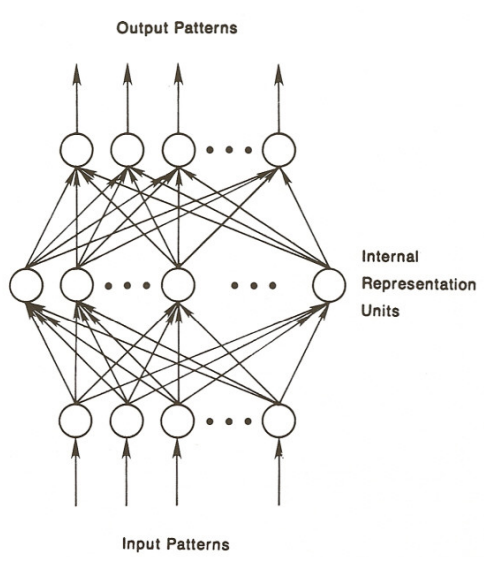.

I will compare the benchmark DBN with an FFNN having the same architecture (the same number of layers and neurons per layer). Due to the difference between the two types of models, we will be able to observe how these examples of two distinct approaches (a supervised and an unsupervised model) behave in different contexts: classification accuracy, robustness to noise, and robustness to adversarial attacks.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(units_DBN1[0], units_DBN1[1], units_DBN1[2]).to(device)

The FFNN model is trained with te same number of epochs as the read-out layers of the DBN.
With the trained model, it is possible to obtain the classification accuracy for the entire network by taking the output from the last layer, as is typical when dealing with feed-forward models.

In [ ]:
# Training of the feed-forward network
train(ffnn, f_mnist_tr.data.reshape((60000, 784)), epochs=1500)

epoch :   1/1500, loss = 2.3044
epoch : 101/1500, loss = 1.5028
epoch : 201/1500, loss = 0.9612
epoch : 301/1500, loss = 0.7943
epoch : 401/1500, loss = 0.7070
epoch : 501/1500, loss = 0.6432
epoch : 601/1500, loss = 0.6012
epoch : 701/1500, loss = 0.5651
epoch : 801/1500, loss = 0.5338
epoch : 901/1500, loss = 0.5112
epoch : 1001/1500, loss = 0.4853
epoch : 1101/1500, loss = 0.4763
epoch : 1201/1500, loss = 0.4587
epoch : 1301/1500, loss = 0.4561
epoch : 1401/1500, loss = 0.4425


In [ ]:
# Accuracy computation for the feed-forward network
predictions_ffnn = ffnn(f_mnist_te.data.reshape((10000, 784)))
compute_accuracy(predictions_ffnn, f_mnist_te.targets)

0.8319000005722046

Remarkably, despite being trained in an unsupervised way, the DBN performs better in a classification task than a FFNN with the same architecture. This indicates that, indeed, the representation learning performed by the DBN could be used for a task such as classifying data, even if at the beginning it was only trained to learn the hidden patterns in the data and had no labels to discern among classes.

## Response to noise

It is also possible to check the robustness to distortions in the input for the two models (DBN and FFNN). To do this, some random noise can be injected to the images before they go through a classification process.
<br>

Below, there is an example with one image:


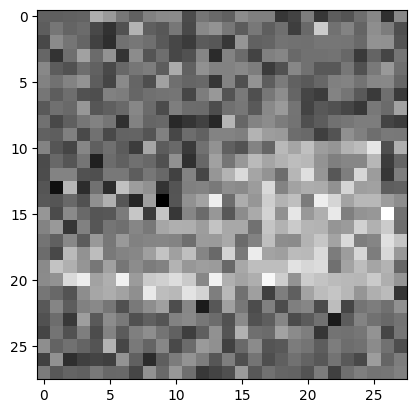

In [ ]:
# Injecting some noise to the input
def inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape, device = device)*noise_level
  return mnist_data + random_gaussian_tensor

noise_level = 0.3
mnist_test_with_noise = inject_noise(f_mnist_te.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

Now, with these noisy stimuli, the new overall accuracies can be obtained, both for the DBN models and for the FFNN.

In [ ]:
# Function to get the accuracy at a given noise level
def get_accuracy_values_at_noise_level(noise_level):

  f_mnist_test_with_noise = inject_noise(f_mnist_te.data, noise_level)  # first, let's create noisy test images

  # Computing the DBN representations
  hidden_repr_model1_noisy = get_all_hidden_repr(dbn_f_mnist1, input=f_mnist_test_with_noise)

  # Computing the accuracies for the previously-trained read-out classifiers, but with the noisy data
  acc_mod1_noisy = test_all_layers(hidden_repr_model1_noisy, linear_classifiers_model1)

  accuracy_first_hidden = acc_mod1_noisy[0]
  accuracy_second_hidden = acc_mod1_noisy[1]
  accuracy_third_hidden = acc_mod1_noisy[2]

  # Computing the accuracies for the feed-forward model with the noisy data
  predictions_ffnn_noisy = ffnn(f_mnist_test_with_noise.reshape((10000, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, f_mnist_te.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
# Executing and printing the accuracy of the different read-outs and the FFN
# with noisy data as input for a fixed noise level
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.807
Accuracy of H2 read-out: 0.823
Accuracy of H3 read-out: 0.824
Accuracy of FF network : 0.787


We can see that, even from the read-out at the first layer, the DBN outperforms the FFNN when dealing with a noisy input. <br>

However, this test was done for a fixed level of noise. By varying the level of noise and computing the accuracies, a psychometric curve is obtained. This is a test in which humans have outperformed neural networks before (Dodge & Karam, 2017):

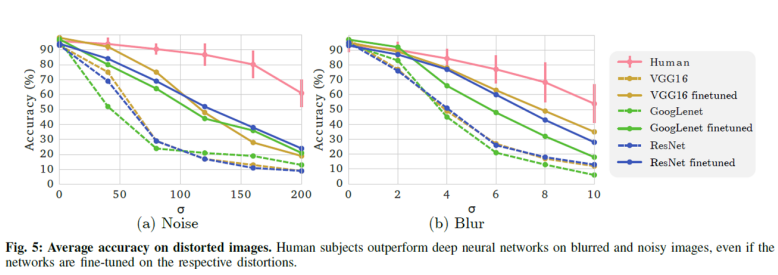

 In this exercise, the psychometric curves are obtained for each of the DBN's hidden layers and for the FFNN.

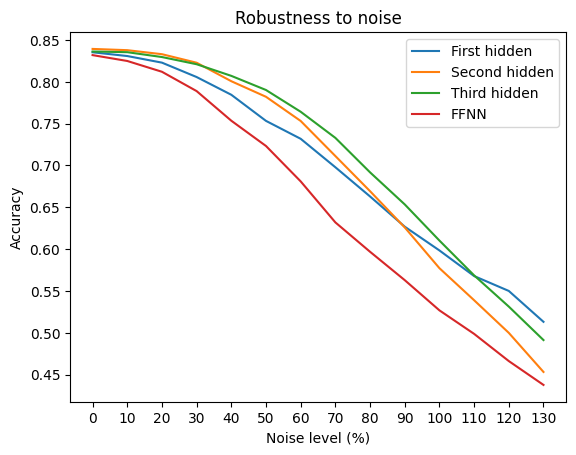

In [ ]:
# Function to obtain the psychometric curves
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

# Execution of the function
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

All layers of the DBN outperform the FFNN with respect to their robustness to noise. What is particular in this case is that, although there seems to be some sort of hierarchical performance in the DBN (the first layer is the worst-performing one), the lines cross at some points. For example, at high levels of noise, the third and the second layer decrease their performance more than the first layer.

## Response to adversarial attacks

In this section, the performance in the case of adversarial attacks will be assessed. <br>
An adversarial attack is a malicious
attempt which tries to perturb te input into a new data point such that it is misclassified by the classifier (Goodfellow et al., 2014). This perturbations could by unnoticeable to the human perception, but they could lead into a completely different classification than what would happen with the clean input. Below, there is an example by Goodfellow et al. (2014):

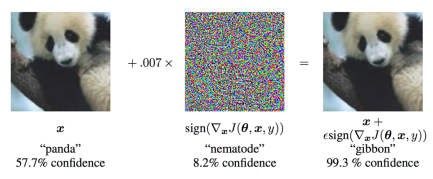

In this experiment, the adversarial attack is implemented with the fast gradient sign method, as it is formulated in the following reference: https://jaketae.github.io/study/fgsm/. <br>

This attack is made by modifying the images based on the sign of the gradient of the error with respect to the input: <br>

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [ ]:
# As a side note, it is worth mentioning that, to evaluate the response of the DBN model against adversarial attacks,
# what will be used is a class for DBN objects
# that performs the forward pass using probablities instead of samples as RBM outputs (in order to backpropagate the gradient).
# This class allows to do the read-out at a given level.
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_f_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_f_mnist = dbn_f_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_f_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_f_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v) # probabilities and output of the pass (comentario mío)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
# Instatiation of an object of the DBNWithReadOut
dbn_with_readout = DBNWithReadOut(dbn_f_mnist1, linear_classifiers_model1, readout_level=2)

In [ ]:
# Function to perform an adversarial attack on an image (auxiliary for a different function later on)
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

To see the effect tat the attack has on an image, firstly, we take a look at an undistorted image and how the previously trained model classifies it:

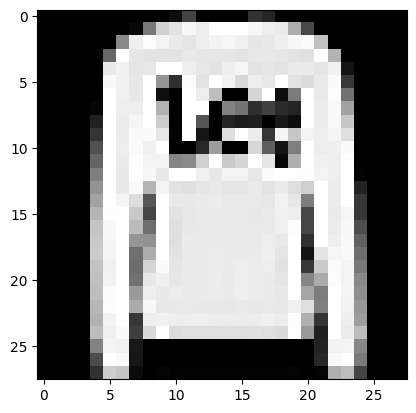

In [ ]:
# Showing a sample of a clean image
test_sample_idx = 1
test_image = f_mnist_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap="gray")

In [ ]:
# Looking at the predictions made by the models (clean image)
test_image.requires_grad_()
dbn_outputs = dbn_with_readout(test_image)
dbn_prediction = torch.argmax(dbn_outputs)
ffnn_outputs = ffnn(test_image)
ffnn_prediction = torch.argmax(ffnn_outputs)
print(f"The prediction of the DBN for this clean sample is {dbn_prediction}: {f_mnist_te.classes[dbn_prediction]}.")
print(f"The prediction of the FFNN for this clean sample is {ffnn_prediction}: {f_mnist_te.classes[ffnn_prediction]}.")

The prediction of the DBN for this clean sample is 2: Pullover.
The prediction of the FFNN for this clean sample is 2: Pullover.


Now, we can execute the adversarial attack and see how it affects the models' predictions. Since the adversarial attack takes into account the loss and the gradient of each model, each model has its own adversarial attack.

In [ ]:
# Executing the adversarial attack on the test image
epsilon = 0.2  # strenght of the attack
test_image_label = f_mnist_te.targets[test_sample_idx].unsqueeze(0)  # ground truth label for that image

In [ ]:
# Function to perform the attack based on the loss and gradient of each model
def adv_attack_model(attacked_model, model_outputs, model_label):
  loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # loss value
  attacked_model.zero_grad()
  loss_value.backward()
  image_grad = test_image.grad.data  # gradient of the pixels w.r.t. the loss
  perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

  perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
  __ = plt.imshow(perturbed_image_np.reshape(28,28), cmap="gray")

  attacked_model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
  attacked_model_prediction = torch.argmax(attacked_model_outputs)
  print(f"The prediction of the {model_label} for the perturbed sample is {attacked_model_prediction}: {f_mnist_te.classes[attacked_model_prediction]}.")

The prediction of the DBN for the perturbed sample is 2: Pullover.


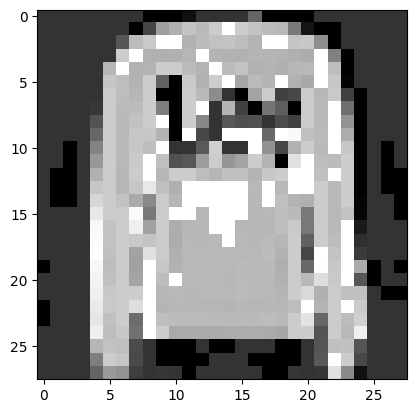

In [ ]:
# Attack for the DBN model
adv_attack_model(attacked_model=dbn_with_readout, model_outputs=dbn_outputs, model_label='DBN')

The prediction of the FFNN for the perturbed sample is 6: Shirt.


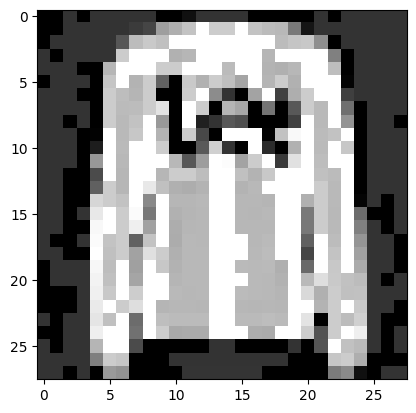

In [ ]:
# Attack for the FFNN model
adv_attack_model(attacked_model=ffnn, model_outputs=ffnn_outputs, model_label='FFNN')

In order to measure the robustness to adversarial attacks, the same approach can performed for the whole test set. That way, the general accuracy can be obtained for the perturbed data. <br>

This test is also made for both the DBN and the FFNN.

In [ ]:
# Function to test the robustness of a given model against an adversary attack with a given epsilon
# It also includes the option to do a reconstruction with the DBN and a given number of steps (whis will be used later)
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True, conf_matrix=False):
    correct = 0
    print_reconstruction = num_steps > 0

    tensor_targets = torch.empty(0).to(device) # a tensor to concatenate the targets for the confusion matrix, if needed
    tensor_noisy_predictions = torch.empty(0).to(device) # a tensor to concatenate the predictions for the confusion matrix, if needed

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28), cmap="gray")
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap="gray")
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_f_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap="gray")
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

        if conf_matrix:
          # Append the noisy predictions and the targets to feed the confusion matrix when needed
          tensor_targets = torch.cat([tensor_targets, target], dim=0)
          tensor_noisy_predictions = torch.cat([tensor_noisy_predictions, final_pred], dim=0)


    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    if conf_matrix:
      ConfusionMatrixDisplay.from_predictions(tensor_targets.cpu().numpy(), tensor_noisy_predictions.cpu().numpy())
      plt.show()

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/fashion', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

* General robustness to adversarial attacks of the DBN:

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 39.16%



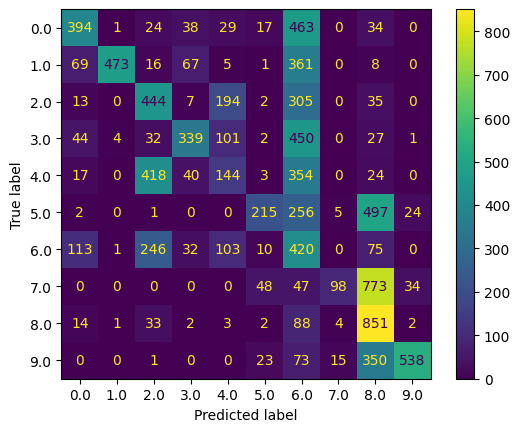

In [ ]:
# Assessment of the general robustness to adversarial attacks of the DBN
adv_acc_DBN = test_robustness_to_attack(dbn_with_readout, device,
                                        test_loader, epsilon=0.1,
                                        num_steps=0,
                                        conf_matrix=True)

Clearly, accuracy drops significantly with respect to the clean samples. It seems that this instance of the adversarial attack influences the network to have a tendency towards classifying many samples as shirts (label number 6), as there are many misclassified examples with that classification. The bag's label (number 8) is also incorrectly assigned to many observations, although in this case, there are still many well-classified examples (in fact, it is the category that has the highest number in the diagonal).

* General robustness to adversarial attacks of the FFNN:

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 27.18%



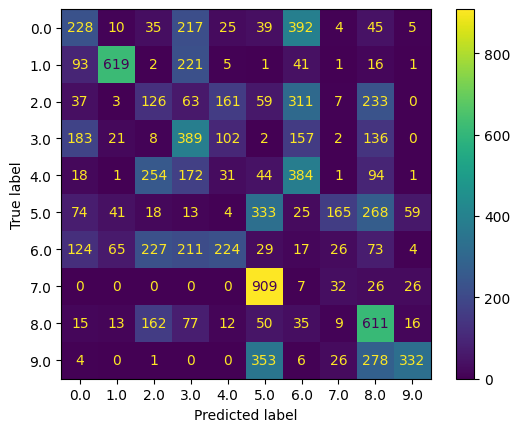

In [ ]:
# Assessment of the general robustness to adversarial attacks of the FFNN
adv_acc_FFNN = test_robustness_to_attack(ffnn, device,
                                         test_loader, epsilon=0.1,
                                         num_steps=0,
                                         conf_matrix=True)

Furthermore, the reduction in the overall accuracy of the FFNN is even more dramatic than the one that the DBN exhibits. In this case, the pattern of a highlighted diagonal is not even distinguishable. Also, it is worth noting that many sneakers (label 7) are now incorrectly classified as sandals (label 5).

### Resisting adversarial attacks

Since it is a generative model, one feature that the Deep Belief Network has is the possibility to reconstruct the visible units based on the learned parameters, based on the fact that they were computed in order to maximize the likelihood of the hidden units given the sensory input. Because of this feature, the DBN has a potential mechanism to resist adversarial attacks by reconstructing the original sample. Hopefully, the reconstructed example would have a representation that is closer to the correct class.
<br>

This reconstruction can be done in one or multiple steps (iterations of bottom-up and top-down passes). To assess the effect of the number of steps, I will test this procedure with three numbers of steps: 1, 3 and 5.

* One step of top-down reconstruction from the generative model

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



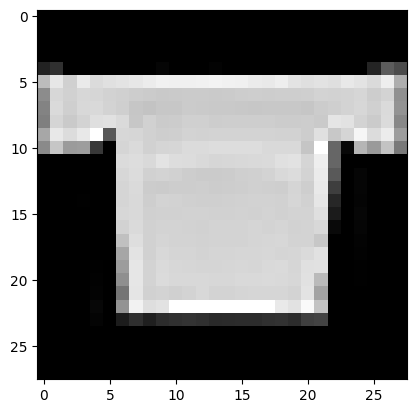


Here's a perturbed sample:



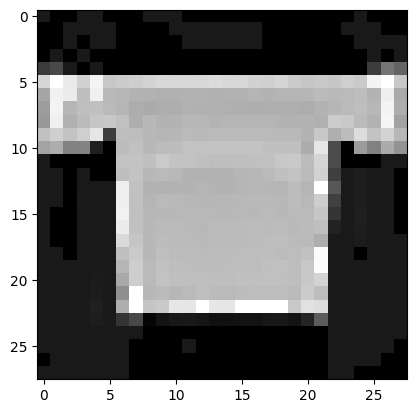


Here's what a 1-steps reconstructed sample looks like:



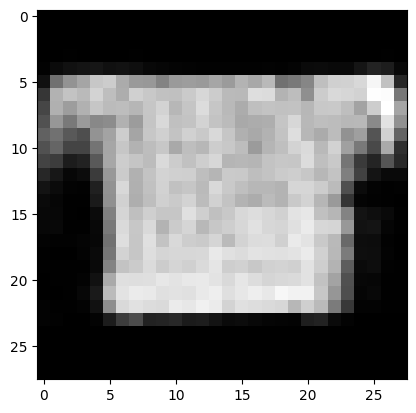


Epsilon: 0.1
Test Accuracy: 34.34%



In [ ]:
one_step_rec_acc = test_robustness_to_attack(dbn_with_readout, device,
                                             test_loader, epsilon=0.1,
                                             num_steps=1)

* Three steps of top-down reconstruction from the generative model

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



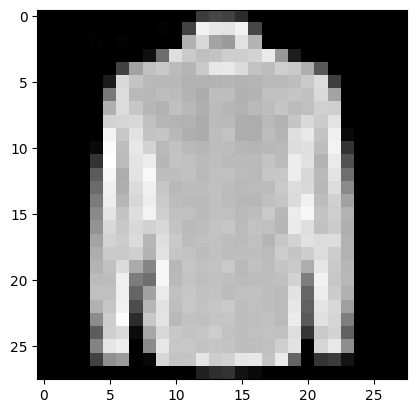


Here's a perturbed sample:



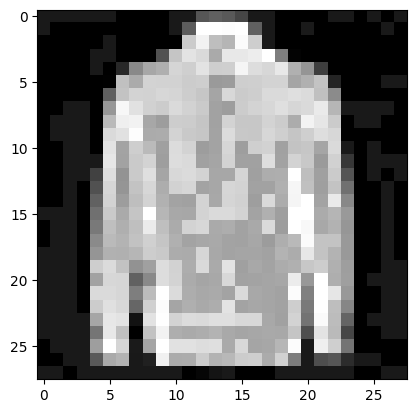


Here's what a 3-steps reconstructed sample looks like:



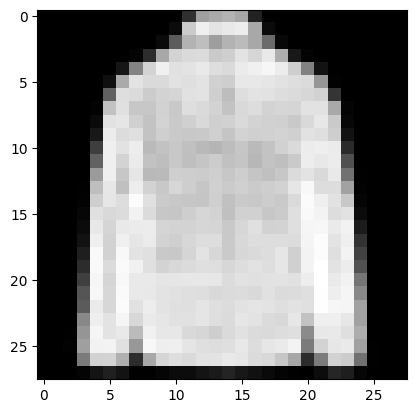


Epsilon: 0.1
Test Accuracy: 31.94%



In [ ]:
three_steps_rec_acc = test_robustness_to_attack(dbn_with_readout, device,
                                               test_loader, epsilon=0.1,
                                               num_steps=3)

* Five steps of top-down reconstruction from the generative model

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



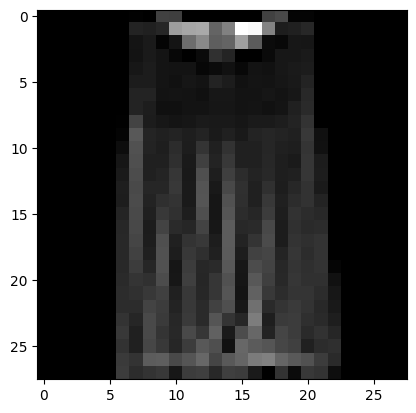


Here's a perturbed sample:



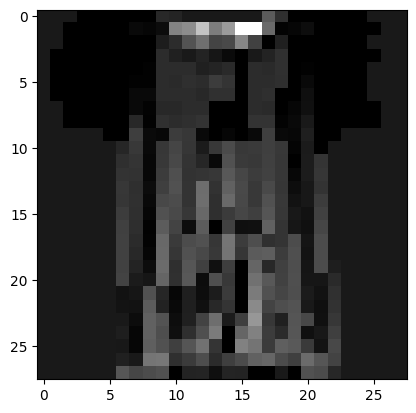


Here's what a 5-steps reconstructed sample looks like:



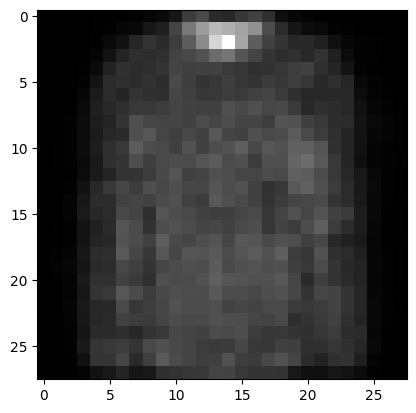


Epsilon: 0.1
Test Accuracy: 31.34%



In [ ]:
five_steps_rec_acc = test_robustness_to_attack(dbn_with_readout, device,
                                               test_loader, epsilon=0.1,
                                               num_steps=5)

Although its performance is still better than the one exhibited by the FFNN, it appears that the reconstruction is not useful to resist adversarial attacks with this dataset and with this configuration. Moreover, the more steps made in the reconstruction, the lower the accuracy, even though the difference between the three-steps and the five-steps reconstructions is small.

### Effect of the $\epsilon$ parameter

Until now, all of the attacks had been made with a fixed value of $\epsilon$, the noise parameter. This parameter allows to control the "strength" of the attack, by adding less or more noise.
<br>
Therefore, it is possible to check the robustness of the models for different levels of noise added with the attack by plotting the general accuracy vs. $\epsilon$.

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_dbn_3 = test_epsilon_values_effect(dbn_with_readout, n_steps=3)
accuracies_dbn_5 = test_epsilon_values_effect(dbn_with_readout, n_steps=5)

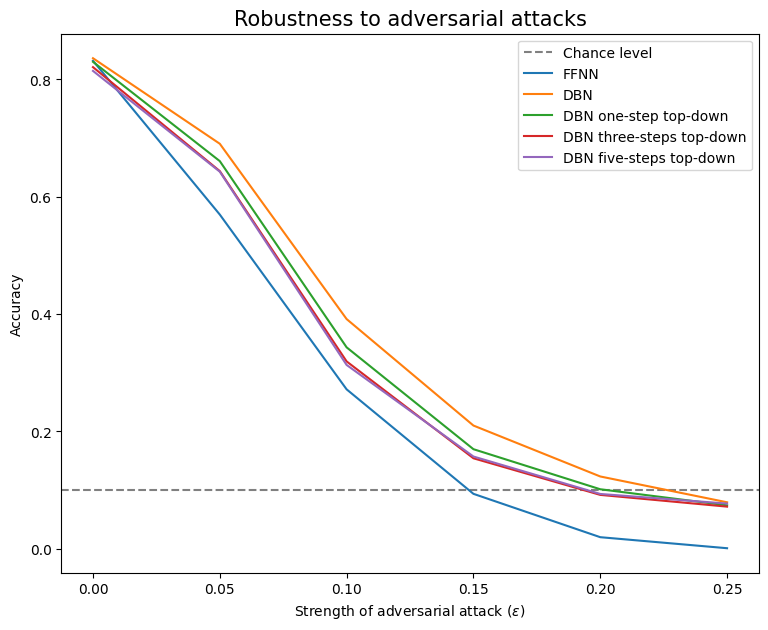

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle='--')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_dbn_3)
__ = ax.plot(epsilon_values, accuracies_dbn_5)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN one-step top-down", "DBN three-steps top-down", "DBN five-steps top-down"])

This result confirms the previous one: the least resilient model against adversarial attacks is the FFNN. However, the reconstruction capabilities of the DBN are not proving to be useful at resisting the attack. In fact, the best response against these adversarial attacks, for all strengths, was displayed by the DBN without reconstructing the sample.

## Conclusions

* A Deep Belief Network, an unsupervised model, is indeed capable of learning internal representations of the data. It can extract distinctive features hidden in the raw input, which can then be utilized for tasks such as classification. In fact, it can even outperform a fully supervised model like a Feed-Forward Neural Network with the same architecture.
* In this experiment, it seems that the number of neurons has a greater impact in terms of performance than the depth of the network. In comparison to a benchmark model, a network with more neurons but one layer less achieved better accuracy than a network with fewer neurons but one layer more.
* With this setting, the DBN outperformed the FFNN regarding the robustness against noise and adversarial attacks. This may imply that the hidden variables obtained by the DBN are a better representation of the sensory data than the variables obtained at the hidden layers of the FFNN.
* Each dataset has its own nuances, and the fact that the fashion MNIST is a more complex dataset than the original MNIST, leads to slightly different results even if the same methodology is applied.
* In spite of the reconstruction capabilities of the DBN, the most robust performance against adversarial attacks was the one exhibited by that model, but without reconstruction. This phenomenon suggests that there might be better architectures or generative approaches to perform this task, although this was beyond the scope of this notebook.


## References

*   Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
*   Zorzi, M., Testolin, A., & Stoianov, I. P. (2013). Modeling language and cognition with deep unsupervised learning: A tutorial overview. Frontiers of Psychology, Volume 4
*   Chan, S. (2018). Chapter 3: Adversarial attack. Purdue Engineering.
*   Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. Science, 313(5786), 504-507
*    Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. Nature, 323, 533–536.
*    Testolin, A., Zorzi, M.,  (2023). Cognition and Computation. In Data Science Master's Program. Università degli Studi di Padova.
*    Tae, J. (2023). Fast Gradient Sign Method. https://jaketae.github.io/study/fgsm/  
*    Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative Adversarial Nets. arXiv:1406.2661
*    Han Xiao, Kashif Rasul, and Roland Vollgraf. (2017, August 28). Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Retrieved from arXiv: cs.LG/1708.07747
*    Hinton, H. (2002) Training Products of Experts by Minimizing Contrastive Divergence. Neural Computation, 14, 1771-1800.
*    Dodge, S., & Karam, L. (2017). A Study and Comparison of Human and Deep Learning Recognition Performance Under Visual Distortions. arXiv:1705.02498